C:\Users\Masashi\Anaconda3\lib\site-packages\matplotlib\__init__.py:962: UserWarning: Duplicate key in file "C:\Users\Masashi\.matplotlib\matplotlibrc", line #202
  (fname, cnt))


31
0


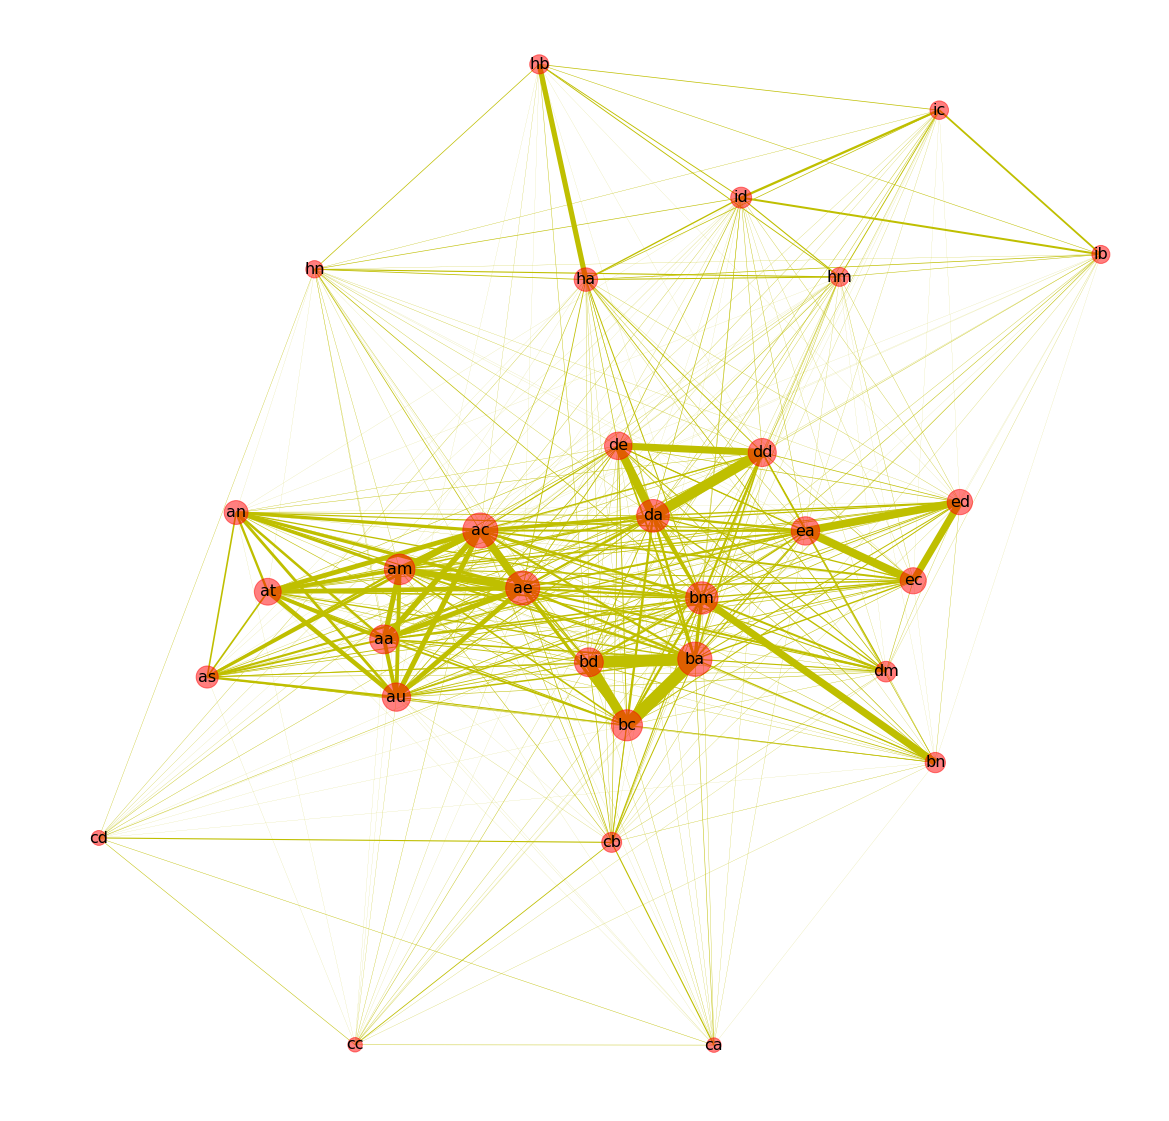

In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import scipy as sp
import codecs
import matplotlib.pyplot as plt
import itertools
import networkx as nx
import string
%matplotlib inline

def csv_reader(file_name):
    # dataの読み込み。本来はPostgreSQL上に保存してあるが、今回はローカルに引っ張ってきたCSVデータを利用
    # unicodeエラーとヘッダー自動割り当てに対処して読み込み
    with codecs.open(file_name, "r", "Shift-JIS", "ignore") as file:
        df = pd.read_csv(file, header=None, delimiter=",")
    return df


def make_student_distribution_df(student_df):
    student_df_as_array = np.array(student_df)
    gakubu_gakka_code = []
    for i in student_df_as_array:
        code = i[0][2:4]
        if code not in gakubu_gakka_code:
            gakubu_gakka_code.append(code)
    students_sum_each_gg = [0 for i in gakubu_gakka_code]
    for i in student_df_as_array:
        code = i[0][2:4]
        for n,c in enumerate(gakubu_gakka_code):
            if code == c:
                students_sum_each_gg[n] +=1 

    student_distribution = pd.DataFrame({
        "gakubu_gakka":gakubu_gakka_code,
        "students_sum":students_sum_each_gg,
    })
    student_distribution = student_distribution.sort_values(by="students_sum",ascending=False)
    return student_distribution

def generate_edge_list(subject_df):
    subject_df_as_array = np.array(subject_df)
    subject_list = []
    for i in subject_df_as_array:
        sub = i[1]
        if sub not in subject_list:
            subject_list.append(sub)

    edge_list = []
    for s in subject_list:
        gakubu_gakka_code = []
        for i in subject_df_as_array:
            if i[1] == s:
                code = i[0][2:4]
                if code not in gakubu_gakka_code:
                    gakubu_gakka_code.append(code)
        if len(gakubu_gakka_code) > 1: 
            for v in itertools.combinations(gakubu_gakka_code, 2):
                edge_list.append(v[0] + " " + v[1])

    return edge_list

def edge_list2txt(edge_list, output_file):
    outfp = open(output_file, 'w',encoding="utf-8")
    for i, line in enumerate(edge_list):
        try:
            outfp.write(str(line))
            outfp.write('\n')
        except:
            pass
    outfp.close()

def gakubu_gakka_edge_counter(student_distribution, edge_list):
    gg_list = list(student_distribution.index)
    gg_edge_count = [0 for i,_ in enumerate(gg_list)]
    for i in edge_list:
        for n,g in enumerate(gg_list):
            if g in i:
                gg_edge_count[n] += 1
    gg_edge = pd.DataFrame({
        "gg":gg_list[:-1],
        "count":gg_edge_count[:-1],
    })
    return gg_edge

if __name__ == "__main__":
    subject_df = csv_reader("subjects_830.csv")
    student_df = csv_reader("students_830.csv")
    subject_df.columns = ["0","1","2","st_id","sub_name","5","6","score","final_score","class_year","semister","teacher","gpa","sub_category","category","15","16"]
    student_df.columns = ["st_id","grade","enter_year","seasons","gpa"]
    subject_df = subject_df[["st_id","sub_name","score","final_score","class_year","semister","teacher","gpa","sub_category","category"]]
    student_df = student_df[["st_id","enter_year","gpa"]]


    student_distribution = make_student_distribution_df(student_df)
    student_distribution_as_array = np.array(student_distribution)
    student_distribution = student_distribution.set_index('gakubu_gakka')

    cleaned_df = subject_df.copy()
    cleaned_df = np.array(cleaned_df)
    cleaned_list = []
    for i in cleaned_df:
        if i[8] == "＊必）言語Ａ＊" or i[8] == "＊必）言語Ｂ＊":
            pass
        elif i[8] == "＊学びの精神＊" or i[8] == "＊多彩な学び，スポ＊":
            pass
        elif i[0][:2] == "15":
            pass
        elif i[0][2:4] == "ｈｍ":
            pass
        else:
            cleaned_list.append(i)
    cleaned_df = pd.DataFrame(cleaned_list)
    cleaned_df.columns = ["st_id","sub_name","score","final_score","class_year","semister","teacher","gpa","sub_category","category"]

    edge_list = generate_edge_list(cleaned_df)
    edge_list2txt(edge_list, "cleaned_edge_list.txt")
    gg_edge = gakubu_gakka_edge_counter(student_distribution, edge_list)

    # G = nx.read_edgelist('edge_list.txt', nodetype=str)
    G = nx.read_edgelist('cleaned_edge_list.txt', nodetype=str)

    G = nx.Graph()
    G.add_nodes_from([(data[1], {"count":data[0]}) for data in np.array(gg_edge)])

    # ノード数とエッジ数を出力
    print(nx.number_of_nodes(G))
    print(nx.number_of_edges(G))

    for edge in edge_list:
        edges = edge.split()
        tag0,tag1 = edges[0], edges[1]
        if not G.has_node(tag0) or not G.has_node(tag1):
            continue
        if G.has_edge(tag0, tag1):
            G[tag0][tag1]["weight"] += 1
        else:
            G.add_edge(tag0, tag1, weight=1)

    plt.figure(figsize=(20, 20)) 
    pos = nx.spring_layout(G, k=0.7)
    
    #PageRankの追加
    pr = nx.pagerank(G)
    edge_width = [ d['weight']*0.1 for (u,v,d) in G.edges(data=True)]
    nx.draw_networkx_edges(G, pos, edge_color='y', width=edge_width)
    
    #node_sizeにPageRankの値を組み込む
    nx.draw_networkx_nodes(G, pos, node_color='r', alpha=0.5, node_size=[20000*v for v in pr.values()])
    nx.draw_networkx_labels(G, pos, font_size=16)
    
    plt.axis('off')
    plt.savefig("学部学科ネットワーク.png",format="PNG")
    plt.show()